In [7]:
# Entrainement du modèle à implémenter
!pip install nltk
!pip install sklearn
!pip install gensim
!pip install textblob
!pip install python-Levenshtein

     |████████████████████████████████| 1.5 MB 370 kB/s eta 0:00:01
     |████████████████████████████████| 303 kB 1.3 MB/s eta 0:00:01
  Using cached tqdm-4.61.0-py2.py3-none-any.whl (75 kB)
     |████████████████████████████████| 284 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 1.3 MB/s eta 0:00:01


In [200]:
from nltk.tokenize import RegexpTokenizer
def article_tokenize_other(text):
    if type(text)!= str:
        raise Exception("The function takes a string as input data")
    else:
        # 1. On extrait les abbreviations
        tokenizer = RegexpTokenizer('[a-zA-Z]\.[a-zA-Z]') #Construction de l'objet tokenizer
        abrevtokens = tokenizer.tokenize(text) #application de la methode tokenize() a l'objet lui permettant d'extraire les abreviations
        # 2. On extrait les mots et les nombres
        tokenizer = RegexpTokenizer('[a-zA-Z]{2,}|\d+\S?\d*')
        wordtokens = tokenizer.tokenize(text)
        return abrevtokens + wordtokens


In [201]:
# représentation des données : choix TF-IDF
# construction de l'index inversé
from collections import OrderedDict
import pickle
import math
def inverse_index():    
    with open('group10_sentiment140_preprocessed.pickle', 'rb') as f1:
        OL = pickle.load(f1)
    n = 0
    index = OrderedDict()
    for i in range(len(OL)):
        n = n + 1
        terms = article_tokenize_other(OL[i]['text'])
        for term in terms:
            if term in index.keys():
                index[term].append(n)
            else:
                index[term] = list()
                index[term].append(n)
    return index


In [247]:
# entrainement d'un modèle Doc2Vec et inférence de nouveaux vecteurs
# Import libraries
import pickle
from gensim.models.doc2vec import Doc2Vec
from gensim.models import doc2vec
from collections import namedtuple
import random
def training(data_file):  # data_file est un fichier en fromat .pickle dont la lecture donne une liste de 'str'
    # Load data
    doc1 = list()
    with open(data_file, 'rb') as f1:
        OL = pickle.load(f1)
    
    for i in range(0,1000): # fichier trop volumineux, je ne prend que les 20000 premiers tweets
        if OL[i]!=None :
            doc1 = doc1 + article_tokenize_other(OL[i])

    # Transform data  
    docs = []
    analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
    for i, text in enumerate(doc1):
        words = text.lower().split()
        tags = [i]
        docs.append(analyzedDocument(words, tags))

    # Train model (set min_count = 1, if you want the model to work with the provided example data set)

    alpha_val = 0.025        # Initial learning rate
    min_alpha_val = 1e-4     # Minimum for linear learning rate decay
    passes = 10              # Number of passes of one document during training

    alpha_delta = (alpha_val - min_alpha_val) / (passes - 1)

    model = doc2vec.Doc2Vec( vector_size = 498 , window = 5, min_count = 1, workers = 4)

    model.build_vocab(docs) # Building vocabulary

    for epoch in range(passes):
        print('epochs', epoch)

        # Shuffling gets better results

        random.shuffle(docs)

        # Train

        model.alpha, model.min_alpha = alpha_val, alpha_val
        #total_examples=self.corpus_count

        model.train(docs,total_examples=model.corpus_count, epochs=model.epochs)
        
        # Logs

        print('Completed pass %i at alpha %f' % (epoch + 1, alpha_val))

        # Next run alpha

        alpha_val -= alpha_delta
    return model

# Training with training file and save the model
model_training = training('tweets-for-unsupervised-training.pickle')
model_training.save("modeldoc2Vec.docvectors")

epochs 0
Completed pass 1 at alpha 0.025000
epochs 1
Completed pass 2 at alpha 0.022233
epochs 2
Completed pass 3 at alpha 0.019467
epochs 3
Completed pass 4 at alpha 0.016700
epochs 4
Completed pass 5 at alpha 0.013933
epochs 5
Completed pass 6 at alpha 0.011167
epochs 6
Completed pass 7 at alpha 0.008400
epochs 7
Completed pass 8 at alpha 0.005633
epochs 8
Completed pass 9 at alpha 0.002867
epochs 9
Completed pass 10 at alpha 0.000100


In [202]:
# Modèle TFIDF : calcul de similarité entre deux textes
from sklearn.feature_extraction.text import TfidfVectorizer
def cosine_sim(text1, text2):
    vectorizer = TfidfVectorizer(tokenizer=article_tokenize_other, ngram_range=(1,1))
    tfidf =  vectorizer.fit_transform([text1, text2])
    return ((tfidf*tfidf.T).A)[0,1]


In [96]:
# analyse qualitative de tweets similaires et dissimilaires: similarite cosinus avec le modèle TF-IDF
import pickle
def similarite_cosinus_TFIDF():
    # on ouvre le fichier prétraité et on récupère les textes des tweets
    with open('group10_sentiment140_preprocessed.pickle', 'rb') as f1:
            OL = pickle.load(f1)

    i = 0
    ten_tweets = list()
    while i < 10 : #récupération des dix premiers tweets
        ten_tweets.append(OL[i]['text'])
        i+=1
    min = 1
    max = -1
    liste_similarité = list() # la liste des triplets (tweet, le plus qui lui est le plus similaire, celui qui lui est le moins similaire)
    t_most_similar=""
    t_less_similar=""
    for text in ten_tweets: # calcul des similarités
        for d in OL[10:len(OL)]:
            sim = cosine_sim(text, d['text'])            
            if sim <= min :
                min = sim
                t_less_similar=d['text']
            elif sim >= max:
                max = sim
                t_most_similar = d['text']
        liste_similarité.append((text,t_most_similar,t_less_similar))
    return liste_similarité


In [203]:
#calcul la similarité entre deux vecteurs en faisant un produit scalaire
def cosine_sim_dv(v_1, v_2):
    s = 0
    n_1 = 0
    n_2 = 0
    for i in range(len(v_1)):
        s = s + v_1[i]*v_2[i]
        n_1 = n_1 + v_1[i]*v_1[i]
        n_2 = n_2 + v_2[i]*v_2[i]
    return s/(n_1*n_2)

In [153]:
# analyse qualitative de tweets similaires et dissimilaires: similarite cosinus avec le modèle doc2Vec

def similarite_cosinus_doc2Vec():
    model = Doc2Vec.load("modeldoc2Vec.docvectors") # chargement du modèle
    with open('group10_sentiment140_preprocessed.pickle', 'rb') as f1:
            OL = pickle.load(f1)
    # récupération des dix premiers tweets
    i = 0
    ten_tweets = list()
    while i < 10 : #récupération des dix premiers tweets
        ten_tweets.append(OL[i]['text'])
        i+=1
    min = 1
    max = -1
    liste_similarité = list() # la liste des triplets (tweet, le plus qui lui est le plus similaire, celui qui lui est le moins similaire)
    t_most_similar=""
    t_less_similar=""
    for text in ten_tweets: # calcul des similarités
        for d in OL[10:len(OL)]:
            sim = cosine_sim_dv(model.infer_vector(article_tokenize_other(text)), model.infer_vector(article_tokenize_other(d['text'])))
            if sim < min :
                min = sim
                t_less_similar=d['text']
            elif sim > max:
                max = sim
                t_most_similar = d['text']
        liste_similarité.append((text,t_most_similar,t_less_similar))
    return liste_similarité

In [204]:
#renvoie la taille d'un dictionnaire : nb de clés
def taille_dico(dic):
    i = 0
    for k in dic:
        i+=1
    return i

In [208]:
# permet de changer un texte en vecteur : TFIDF 
import math
def vectorial_representation_doc(collection,doc,vocabulary):
    index = inverse_index()
    N = taille_dico(collection)
    vector_doc = []
    for term in vocabulary:
        count_term=0
        for token in collection[doc]:
            if token==term:
                count_term=count_term+1
        if token in index :
            vector_doc.append(count_term*math.log(N/len(index[token])))
        else:
            vector_doc.append(count_term)
    return vector_doc

In [125]:
# Implémentation de modèles : Modèle SVC linear : 10_fold cross-validation avec une représentation TFIDF
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import utils
from sklearn import model_selection
lab_enc = preprocessing.LabelEncoder()

with open('group10_sentiment140_preprocessed.pickle', 'rb') as f1: 
            OL = pickle.load(f1)
        
                # load data
index = inverse_index()
vocabulary = list()
for term in index:
    vocabulary.append(term)
tweets_texts = dict()
groupe =list()
for d in OL:
    tweets_texts[d['id']] = article_tokenize_other(d['text'])
    groupe.append(d['polarity'])
data = list()
for k in tweets_texts:    
    data.append(vectorial_representation_doc(tweets_texts,k,vocabulary))

                # paramètres du modèle SVC
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10], 'gamma':[1,10]}

X = np.transpose(np.array(data[0:len(data)])) # données d'apprentissage

for i in range(abs(X.shape[0]-len(groupe))):
    groupe.append(0)
labels = np.transpose(np.array(groupe)) # les etiquettes
svc = svm.SVC()
clf = model_selection.GridSearchCV(svc, parameters, cv=10, scoring='accuracy')   # recherche d'hyperparamètres et validation croisée
clf.fit(X, labels)

print('les meilleurs hyperparamètres',clf.best_params_, ' le cv moyen', clf.best_score_, )
                
            

les meilleurs hyperparamètres {'C': 1, 'gamma': 1, 'kernel': 'rbf'}  le cv moyen 0.822434786285038


In [152]:
# Implémentation de modèles : Modèle SVC linear : 10_fold cross-validation avec une représentation doc2Vec
# Librairies
from sklearn import preprocessing
from sklearn import utils
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from gensim.models import doc2vec
from gensim.models.doc2vec import Doc2Vec
import numpy as np

model = Doc2Vec.load("modeldoc2Vec.docvectors") # chargement du modèle
lab_enc = preprocessing.LabelEncoder() # pour encoder les labels
with open('group10_sentiment140_preprocessed.pickle', 'rb') as f1: 
            OL = pickle.load(f1)

                # load data

train = list()
test = list()
groupe =list()
for i in range(len(OL)):        
    train.append(model.infer_vector(article_tokenize_other(OL[i]['text'])))
    groupe.append(OL[i]['polarity'])
X = np.array(train)         # Initialisation données d'apprentissage

labels = np.transpose(np.array(groupe)) # les etiquettes

            # paramètres du modèle SVC
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10], 'gamma':[1,10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=10, scoring='accuracy')  # recherche d'hyperparamètres et validation croisée
clf.fit(X, labels)

print('les meilleurs paramètres',clf.best_params_, ' le cv moyen', clf.best_score_)

les meilleurs paramètres {'C': 10, 'gamma': 10, 'kernel': 'rbf'}  le cv moyen 0.3855918367346939


In [288]:
# Modèle TextBlob
from sklearn.model_selection import cross_validate
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
# Mise en place du modèle :

# load data
with open('group10_sentiment140_rawdata.pickle', 'rb') as f1:
            OL = pickle.load(f1)
train = list()
test = list()
for i in range(len(OL)-1):
    if OL[i]['polarity']=="positive":        
        train.append((OL[i]['text'],'pos'))
    elif OL[i]['polarity']=="negative":
        train.append((OL[i]['text'],'neg')) 
if OL[len(OL)-1]['polarity'] =="positive":
    test.append(OL[len(OL)-1]['text'],'pos')
elif OL[len(OL)-1]['polarity'] =="negative":
    test.append((OL[len(OL)-1]['text'],'neg'))
    
# création d'un classifieur par passage des donnees 

cl = NaiveBayesClassifier(train)

print('precison du modèle sur le jeu de test', cl.accuracy(test))


(2173, 498)


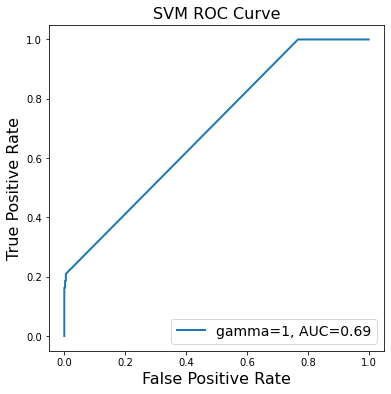

In [244]:
# entrainement du meilleur modèle sur toutes les données : modèle SVC avec les hyperparamètres kernel=rbf, C=1 et gamma=1
import numpy as np
from sklearn import svm
from sklearn import model_selection
from sklearn import preprocessing
from matplotlib import pyplot as plt
from joblib import dump, load
# charger les données
def entrainement_SVC(file):
    with open(file, 'rb') as f1: 
                OL = pickle.load(f1)

                    # load data
    index = inverse_index()
    vocabulary = list()
    for term in index:
        vocabulary.append(term)
    tweets_texts = dict()
    groupe =list()
    for d in OL:
        tweets_texts[d['id']] = article_tokenize_other(d['text'])
        groupe.append(d['polarity'])
    data = list()
    for k in tweets_texts:

        data.append(vectorial_representation_doc(tweets_texts,k,vocabulary))


    X = np.transpose(np.array(data[0:len(data)])) # données d'apprentissage

    for i in range(abs(X.shape[0]-len(groupe))):
        groupe.append(0)
    labels = np.transpose(np.array(groupe)) # les etiquettes

    X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, labels, test_size=0.2)
    # Créer une SVM avec un noyau gaussien de paramètre gamma=0.01

    classifier = svm.SVC(kernel='rbf', C=1, gamma=1)

    # standardiser les données

    std_scale = preprocessing.StandardScaler().fit(X_train)

    X_train_std = std_scale.transform(X_train)
    X_test_std = std_scale.transform(X_test)

    # Entraîner la SVM sur le jeu d'entraînement : pour la dernière phase du problème, on entraine le modèle sur toutes les données X
    print(X.shape)
    classifier.fit( X_train_std, y_train)

    # sauvegarde du modèle

    dump(classifier, 'group10_sentiment140_SVC_finalmodel.pickle') 
    return classifier

                # comportement du modèle en prédiction
classifier = entrainement_SVC('group10_sentiment140_preprocessed.pickle')
            
# prédire sur le jeu de test
y_test_pred = classifier.decision_function(X_test_std)
y_test_pred = y_test_pred.T[2]
fpr, tpr, thr = metrics.roc_curve(y_test, y_test_pred, pos_label=1)
# calculer l'aire sous la courbe ROC
auc = metrics.auc(fpr, tpr)

# créer une figure

fig = plt.figure(figsize=(6, 6))

# afficher la courbe ROC
plt.plot(fpr, tpr, '-', lw=2, label='gamma=1, AUC=%.2f' % auc)

# donner un titre aux axes et au graphique
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM ROC Curve', fontsize=16)

# afficher la légende
plt.legend(loc="lower right", fontsize=14)

# afficher l'image
plt.show()

In [239]:
# prétraitement champ texte
import unicodedata
import re
def normalisation(s):
    s = re.sub(r'http\S+', '', s) # supprime les liens de la chaine
    s = re.sub('[^a-zA-Z0-9\n\. ]', '', s)
    
    try:
        text = s.lower()
        text = unicode(text,'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore') # supprime les accents de la chaine
          
    return str(text, 'utf-8')

In [240]:
# fonction de pretraitement d'un tweet
def preproccess(text):
    return normalisation(text)
    

In [287]:
# inférence de la polarité sur nos tweets collectés

from joblib import dump, load
with open('group10_data@POTUS_projectdata.pickle', 'rb') as f1:  # load data
            OL = pickle.load(f1)

index = inverse_index()
vocab = list()
for term in index:
    vocab.append(term)
tweets = dict()
for i in range(len(OL)):
    for k in OL[i]:   
        tweets[k] = article_tokenize_other(preproccess(OL[i][k]['text']))

model = Doc2Vec.load("modeldoc2Vec.docvectors") # chargement du modèle
cl = load('group10_sentiment140_SVC_finalmodel.pickle') # load SVC model
l = list()
for j in range(len(OL)):
    for k in OL[j]:
        vector = model.infer_vector(article_tokenize_other(preproccess(OL[j][k]['text'])))
        #vector = vectorial_representation_doc(tweets,k,vocab) # vectorisation du texte  
        l.append(vector)
X = np.array(l)
predicted_polarity = cl.predict(X)
ditionnaire = dict()
dictionnaire['predicted_polarity'] = predicted_polarity
OL.append(dictionnaire)
# sauvegarder le fichier avec les prédictions de polarité

In [266]:
#entrainement de TextBlob sur toutes les données

from joblib import dump, load
from sklearn.model_selection import cross_validate
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
# Mise en place du modèle :
def train_TextBlob():
# load data
    with open('group10_sentiment140_rawdata.pickle', 'rb') as f1:
                OL = pickle.load(f1)
    train = list()
    for i in range(len(OL)):
        if OL[i]['polarity']=="positive":        
            train.append((OL[i]['text'],'pos'))
        elif OL[i]['polarity']=="negative":
            train.append((OL[i]['text'],'neg'))
        elif OL[i]['polarity']=="neutral":
            train.append((OL[i]['text'],'neu'))

    # création d'un classifieur par passage des donnees d'apprentissage

    cl = NaiveBayesClassifier(train)
    dump(cl, 'classifier.pickle')
train_TextBlob()

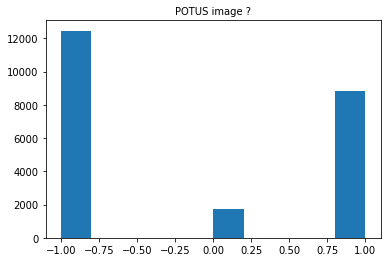

In [286]:
#prédiction de polarité avec TextBlob sur les tweets collectés
from joblib import dump, load
with open('group10_data@POTUS_projectdata.pickle', 'rb') as f1:  # load data
            liste = pickle.load(f1)
dico_pred = dict()
predict = list()
cl = load('classifier.pickle')
for d in liste: 
    p = cl.classify(preproccess(d['full_text']))
    if p=='pos':
        predict.append(1)
    elif p=='neg':
        predict.append(-1)
    else:
        predict.append(0)
dico_pred['predicted_polarity'] = predict      
liste.append(dico_pred)
print(liste)

In [ ]:
# Analyse des 30 premiers tweets pour voir si le modèle prédit bien 
#Liste de predictions des 30 premiers par notre modèle

#[-1, -1, 1, -1, -1, 1, -1, -1, 0, 1, 1, -1, -1, 0, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1]

#Liste des predictions faites à la main des 30 premiers tweets
#[-1, -1, 1, 0, -1, -1, 1, -1, -1, 0, 1, 0, 0, 0, -1, -1, 1, 0, 0, 1, -1, 1, 1, -1, 1, 1, 0, -1, -1]

In [283]:
# Partie Challenge :
from joblib import dump, load
def prediction(tweets):   # renvoie la liste des polarités des tweets
    predict = list()
    cl = load('classifier.pickle')
    with open(tweets, 'rb') as f1: # load data
        liste = pickle.load(f1)
    for tweet in liste:
        p = cl.classify(preproccess(tweet))
        if p=='pos':
            predict.append(1)
        elif p=='neg':
            predict.append(-1)
        else:
            predict.append(0)
    return predict


[-1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 0, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 0, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 0, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 0, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, -1, -1, -1, 0, 1, 0, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 0, 1, 1, -1, 0, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 0, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, 0, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, 1, 1, 0, 0, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 

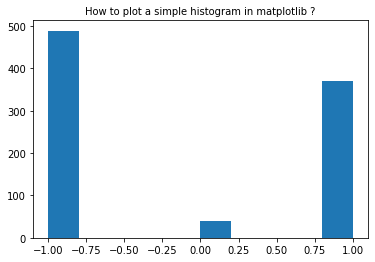

In [284]:
# Analyse des données du projet 
import matplotlib.pyplot as plt
prediction = prediction('testset.pickle')
print(prediction, len(prediction))
with open('g10_testset_predictions.pickle', 'wb') as f:
    pickle.dump(prediction, f)

plt.hist(prediction)

plt.title('How to plot a simple histogram in matplotlib ?', fontsize=10)

plt.savefig("plot_simple_histogramme_matplotlib_01.png")

plt.show()